In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os



import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
np.random.seed(1)

In [3]:
!conda install -y s3fs

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - s3fs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.10.15         |           py36_0         139 KB

The following packages will be UPDATED:

    certifi:         2018.8.24-py36_1     conda-forge --> 2018.10.15-py36_0
    openssl:         1.0.2p-h470a237_0    conda-forge --> 1.0.2p-h14c3975_0
    s3fs:            0.1.5-py36_0                     --> 0.1.6-py36_0     

The following packages will be DOWNGRADED:

    ca-certificates: 2018.8.24-ha4d7672_0 conda-forge --> 2018.03.07-0     


certifi-2018.10.15   | 139 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [4]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [5]:
bucket='sagemaker-us-east-1-074654881237'
prefix = 'prysmian-forecasting' #Used for denoting storage location

sagemaker_session = sagemaker.Session()
role = get_execution_role()

folder1='sagemaker' #First Directory within Bucket
folder2='data' # Second Directory within bucket
folder3='train' # Third Directory within Bucket
data_key = 'TransposedConsumptionEdit.xlsx' #File name


s3_data_path = 's3://{}/{}/{}/{}/{}'.format(bucket, folder1, folder2, folder3, data_key)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [6]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [7]:
freq = 'M'  #Our spreadsheet uses raw month in YY-MMM format. Cannot process this with pandas so I changed it to month end
prediction_length = 5 #How many months into the future we want to predict into the future
context_length = 12 #How much context we want to supply to the algorithm - Year is more than enough

This is the number of time series you're running through the algorithm (This many materials):
67
This is the # of months of data that your spreadsheet has:
88
This is the beginning date:
2011-06-30 00:00:00
2011-06-30     73052.921
2011-07-31     67881.237
2011-08-31     78984.130
2011-09-30     67998.094
2011-10-31     67801.835
2011-11-30     73391.778
2011-12-31     46532.921
2012-01-31     70966.772
2012-02-29     61178.401
2012-03-31     52982.210
2012-04-30     71168.101
2012-05-31     71851.246
2012-06-30     80699.000
2012-07-31     73556.028
2012-08-31     98201.058
2012-09-30     56701.973
2012-10-31     67406.971
2012-11-30     70040.188
2012-12-31     58642.254
2013-01-31     83767.452
2013-02-28     85742.935
2013-03-31     87281.543
2013-04-30    104040.631
2013-05-31     65681.485
2013-06-30     76182.705
2013-07-31     72647.467
2013-08-31     81377.063
2013-09-30     76358.108
2013-10-31    113270.913
2013-11-30     82326.821
                 ...    
2016-04-30    1460

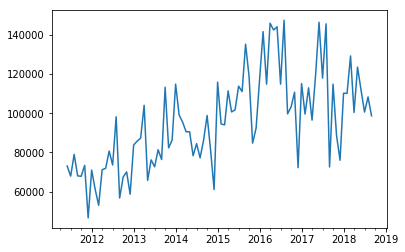

In [8]:
data = pd.read_excel(s3_data_path, parse_dates=True, index_col=0) #Sets index column as the first column in spreadsheet (The Dates)
num_timeseries = data.shape[1] #Looks at the shape of the first column of data to determine the number of time series
data_length=data.index.size #Determines the dynamic length of data in each time series (changes and gets smarter month to month)
print("This is the number of time series you're running through the algorithm (This many materials):")
print(num_timeseries)
print("This is the # of months of data that your spreadsheet has:")
print(data_length)
t0 = data.index[0]
print("This is the beginning date:")
print(t0)
time_series=[] #Defines the structure of the time series data

for i in range(num_timeseries):
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data.iloc[:,i], index=index)) #Must treat this dynamically, so for loop (Length changes monthly)
       
print(time_series[2]) #Visual to make sure data is loaded correctly. No Graph = no bueno amigo
time_series[2].plot()
plt.show()

In [9]:
time_series_training = [] #Creates structure of our training data
for ts in time_series:
    time_series_training.append(ts[:-prediction_length]) #appends everything except the prediction length, default of five months because that's what we're predicting

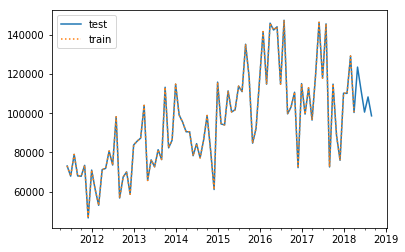

In [10]:
time_series[2].plot(label='test')
time_series_training[2].plot(label='train', ls=':') #Fancy way of determining what we want the model to predict later
plt.legend()
plt.show()

In [11]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat)) #Most annoying process is conversion to JSON data type - makes it easier to dump excel data

In [12]:
encoding = "utf-8"  #Takes JSON to unicode b/c have to encode data for s3 writing
s3filesystem = s3fs.S3FileSystem()  # Data: Excel -> Dataframe -> series appended -> JSON -> UTF-8 byte type -> S3 Bucket JSON. Brutal Dude

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [13]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [14]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "80",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [15]:
estimator.set_hyperparameters(**hyperparameters)

In [16]:
%%time
data_channels = {
    
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2018-10-25-19-16-51-516


2018-10-25 19:16:51 Starting - Starting the training job...
2018-10-25 19:16:56 Starting - Launching requested ML instances.........
2018-10-25 19:18:41 Starting - Preparing the instances for training.........
2018-10-25 19:20:11 Downloading - Downloading input data..
Arguments: train
[10/25/2018 19:20:34 INFO 140089984939840] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/25/2018 19:20:34 INFO 140089984939840] Reading provided configuration from /opt/ml/


2018-10-25 19:20:48 Training - Training image download completed. Training in progress.
2018-10-25 19:20:48 Uploading - Uploading generated training model[10/25/2018 19:20:38 INFO 140089984939840] Epoch[11] Batch[5] avg_epoch_loss=9.862186
[10/25/2018 19:20:38 INFO 140089984939840] Epoch[11] Batch [5]#011Speed: 1572.23 samples/sec#011loss=9.862186
[10/25/2018 19:20:38 INFO 140089984939840] processed a total of 320 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 324.9070644378662, "sum": 324.9070644378662, "min": 324.9070644378662}}, "EndTime": 1540495238.849668, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1540495238.524423}

[10/25/2018 19:20:38 INFO 140089984939840] #throughput_metric: host=algo-1, train throughput=984.54879218 records/second
[10/25/2018 19:20:38 INFO 140089984939840] #progress_metric: host=algo-1, completed 15 % of epochs
[10/25/2018 19:20:38 INFO 140089984939840] loss did not improve for 2 epo


2018-10-25 19:20:54 Completed - Training job completed
Billable seconds: 43
CPU times: user 558 ms, sys: 37.6 ms, total: 596 ms
Wall time: 4min 42s


In [17]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2018-10-25-19-16-51-516
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2018-10-25-19-16-51-516
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2018-10-25-19-16-51-516


---------------------------------------------------------------------------!

In [18]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [19]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [20]:
list_of_df = predictor.predict(time_series_training[:60])
actual_data = time_series[:5]

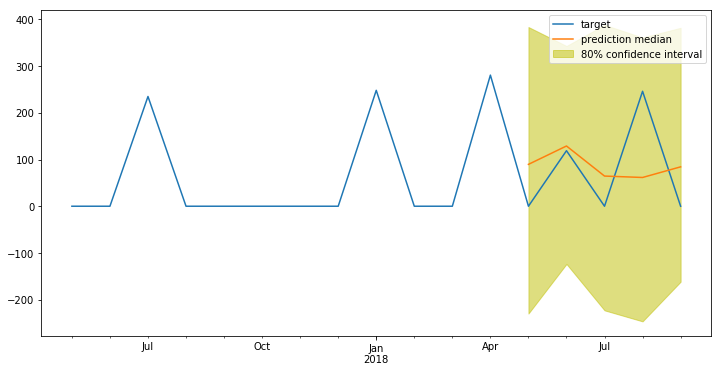

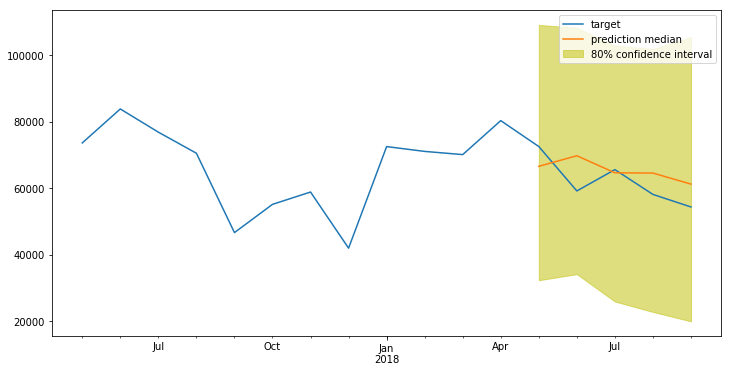

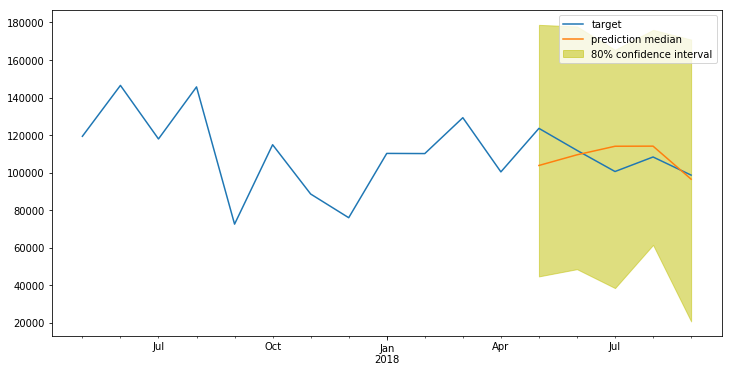

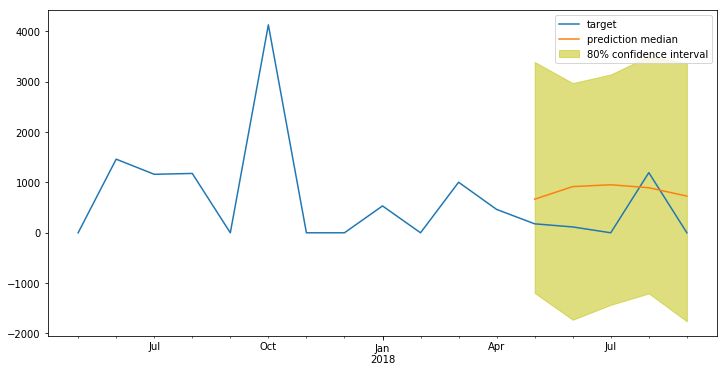

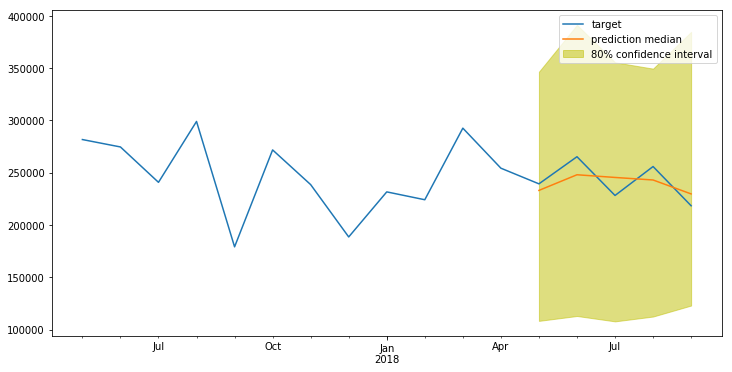

IndexError: list index out of range

<Figure size 864x432 with 0 Axes>

In [21]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [38]:
print(predictor.predict(time_series[65:66
                                   ]))

[                  0.1        0.5        0.9
2018-10-31 -18.366581  13.481967  44.786736
2018-11-30 -25.529459  13.319059  45.850433
2018-12-31 -23.778004  12.070845  53.733257
2019-01-31 -20.478523  18.696316  50.770493
2019-02-28 -23.956913  14.438695  45.440060]


In [ ]:
#sagemaker_session.delete_endpoint(endpoint_name)  #Save my bank account and run this command whenever you're done